# Visualizing High Dimensional data using t-SNE and Autoencoders

This workshop uses an autoencoder and classifier neural networks and the t-SNE algorithm to analyze and visualize the MNIST dataset (images of handwritten digits).

22 March 2021<br>
<i>Joe Bretz</i>

Based on:
###### Building Autoencoders in Keras by Francois Chollet
https://blog.keras.io/building-autoencoders-in-keras.html <br>

###### Keras: Multiple outputs and multiple losses by Adrian Rosebrock
https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

<br><br><br>
# 1. Import Packages and Data
We start by importing the needed packages and functions:<br>
<b>tensorflow:</b> open source platform for machine learning, particularly deep neural networks. Keras is a python interface atop TensorFlow. We'll use these libraries for the neural networks (autoencoder/classifier).<br>
<b>sklearn:</b> scikit-learn is another open source platform for machine learning, featuring classification, regression, and clustering algorithms. We'll use this library for t-SNE.<br>
<b>pandas/numpy:</b> popular packages for handling data in python.<br>
<b>matplotlib:</b> an object-oriented API for creating plots.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn import manifold

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load MNIST dataset
The MNIST dataset of binary images of handwritten digits (https://keras.io/api/datasets/mnist/) comes already split into train and test sets with images (X) and labels (Y).

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('X_train.shape =', X_train.shape)
print('Y_train.shape =', Y_train.shape)
print('X_test.shape =', X_test.shape)
print('Y_test.shape =', Y_test.shape)

X_train.shape = (60000, 28, 28)
Y_train.shape = (60000,)
X_test.shape = (10000, 28, 28)
Y_test.shape = (10000,)


### Preprocess the data
Since the MNIST image data has values 0-255, we divide by the max to rescale the data. We also reshape (flatten) the image data to one a 1-dimension array: 28x28=784

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print('X_train.shape =', X_train.shape)
print('X_test.shape =', X_test.shape)

X_train.shape = (60000, 784)
X_test.shape = (10000, 784)


### Plot some examples
from both the train and test sets with their given label.

Training Examples


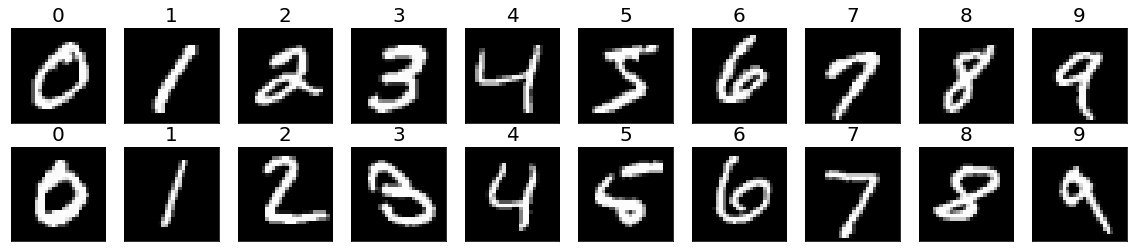

Testing Examples


In [4]:
train09 = [1,3,5,7,2,0,13,15,17,4]   # Index list for 0 through 9 digits in train set
test09 = [3,2,1,18,4,8,11,0,61,7]    # Index list for 0 through 9 digits in test set
n = len(train09)  # How many digits we will display = 10

print('Training Examples')
plt.figure(figsize=(20, 4))
for num, ber, i in zip(train09, test09, range(n)):   # for-loop through chosen examples of train/test set
    # Display Training Examples
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[num].reshape(28,28))   # Since images were flattened, they need to be reshaped to 28x28
    plt.gray()
    ax.set_title(Y_train[num], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Testing Examples
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test[ber].reshape(28, 28))
    plt.gray()
    ax.set_title(Y_test[ber], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print('Testing Examples')

<br><br><br>
# 2. Autoencoder Neural Network

The next step is to set up the autoencoder neural network architecture.

### Basic Neural Network
An example neural network architecture with input/hidden/output layers:
<img src="NN_img.png" width=500>

The steps for training a neural network are:<br>
<b>1.</b> Input data and forward propagation<br>
<b>2.</b> Calculate loss<br>
<b>3.</b> Back propagation to update parameters (weights and biases)<br>
<b>4.</b> Repeat<br>

### Autoencoder architecture
An autoencoder is considered a self-supervised machine learning algorithm, because "ground-truth" labels are <b>not</b> needed to train it. The autoencoder is trained to return an output identical to the input, <i>i.e.</i> the identity function. However the autoencoder can reduce the dimension with a bottleneck in the architecture:
<img src="AE_img.png" width=500>

The reduced dimension forces the autoencoder to learn the most "salient" features of the data, expressed in the encoded "latent space".

### Define Autoencoder
Here we set up a very basic autoencoder model with single encoding and decoding layers.<br>
An Input() layer is used to establish the size of the input data (784).<br>
The encoding layer reduces the dimension of the input data down to only 32 dimensions.<br>
The decoding layer expands the encoded data back up to the 784 dimensions, the full size of the original images.

In [31]:
# Encoder layer(s)
enc1_i = layers.Input(shape=(784,))
enc1_1 = layers.Dense(32, activation='relu')(enc1_i)   # Dense = Fully connected. 'relu' = Rectified Linear Unit

# Decoder layer(s)
dec1_1 = layers.Dense(784, activation='sigmoid')(enc1_1)

# Define autoencoder model
autoencoder_1 = Model(inputs=enc1_i, outputs=dec1_1)

# Compile autoencoder
autoencoder_1.compile(optimizer='adam', loss='mse')

Common activation functions:
<img src="act_img.png" width=300>

### Train the autoencoder
The next step is to train the autoencoder using .fit().<br>
The input training data (x) is X_train, and the output to compare against the encoded+decoded input (y) is also X_train.<br>
Validation data are used to test the model but not for training.

In [35]:
history_1 = autoencoder_1.fit(x=X_train,
                              y=X_train,
                              validation_data=(X_test, X_test),
                              epochs=5,
                              batch_size=256,
                              shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0165 - val_loss: 0.0153
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.0150 - val_loss: 0.0140
Epoch 3/5
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0136 - val_loss: 0.0126
Epoch 4/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0126 - val_loss: 0.0119
Epoch 5/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0120 - val_loss: 0.0114


### Plot the loss during training

Minima:
 loss        0.011987
val_loss    0.011423
dtype: float64


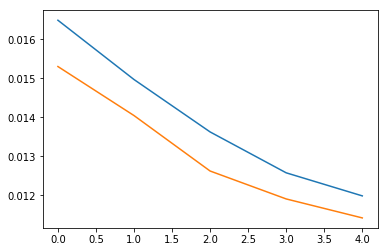

In [36]:
print('Minima:\n', pd.DataFrame(history_1.history).min())
plt.plot(history_1.history['loss'], label='train loss')
plt.plot(history_1.history['val_loss'], label='test loss')

### Compare autoencoded output to original images

Original


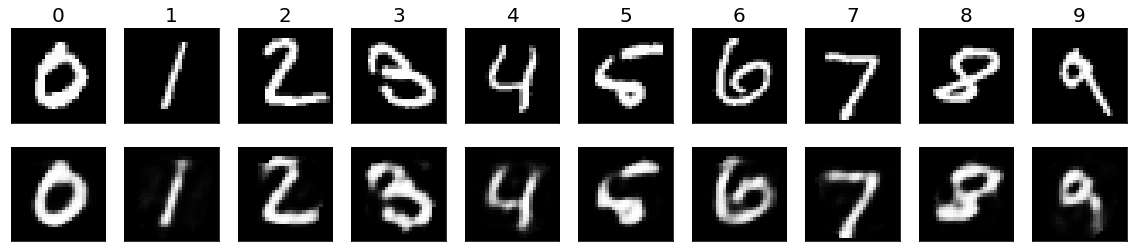

Reconstruction


In [37]:
# Generate autoencoded images
decoded1_test = autoencoder_1.predict(X_test[test09])

print('Original')
plt.figure(figsize=(20, 4))
for num, i in zip(test09, range(n)):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[num].reshape(28,28))
    plt.gray()
    ax.set_title(Y_test[num], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded1_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print('Reconstruction')

<br><br><br>
# 3. t-SNE = t-distributed Stochastic Neighbor Embedding

t-SNE uses a Student's t-distribution to determine how similar/close two points are in high dimensional space.

<img src="t-dis_img.png" width=300>

A key tunable parameter of t-SNE is <b><i>perplexity</i></b>. Perplexity can be loosely thought of as a guess for the number of nearby neighbors a point has. It's best to compare t-SNE results for various perplexity values to avoid misleading results.<br><br>
An interactive resource for building an intuition around using t-SNE: https://distill.pub/2016/misread-tsne/

### Generate encodings from the train and test sets

In [18]:
# Define encoder model (No need to .compile/.fit since weights are already trained)
encoder_1 = Model(inputs=enc1_i, outputs=enc1_1)

N = 1000;   # Number of examples

# Generate encodings
encoded_1_train = encoder_1.predict(X_train[:N])
encoded_1_test = encoder_1.predict(X_test[:N])

encoded_1_train.shape, encoded_1_test.shape

((1000, 32), (1000, 32))

### Fit t-SNE algorithm to encodings
This cell takes ~10s to run.

In [19]:
%%time
tsne = manifold.TSNE(n_components=2,   # Reduce dimensions to 2 for plotting
                     perplexity=80,    # Approximate number of points in a cluster
                     learning_rate=200,
                     n_iter=400,       # Number of 
                     init='pca',       # Initialize encodings in 2D using Principal Component Analysis
                     random_state=0)   # Set random seed for reproducability

train_1_tsne = tsne.fit_transform(encoded_1_train)
test_1_tsne = tsne.fit_transform(encoded_1_test)

train_1_tsne.shape, test_1_tsne.shape

Wall time: 11.4 s


((1000, 2), (1000, 2))

### Plot t-SNE results

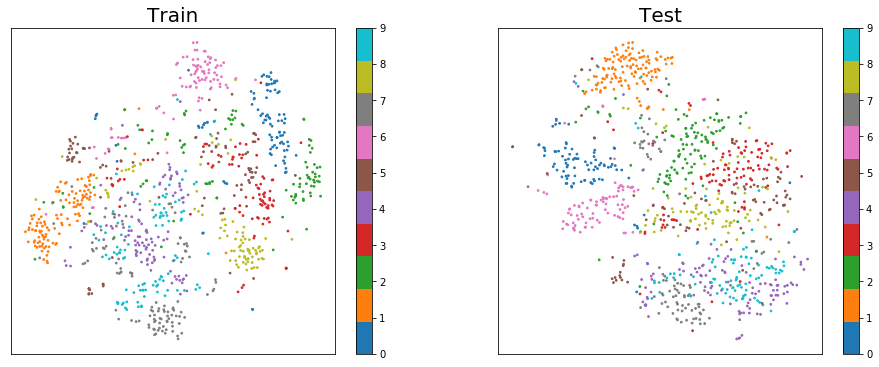

In [20]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(train_1_tsne[:,0], train_1_tsne[:,1], s=3, c=Y_train[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.scatter(test_1_tsne[:,0], test_1_tsne[:,1], s=3, c=Y_test[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Test', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Some clustering is apparent, but there is significant overlap and not much separation between clusters.

<br><br><br>
# 4. Autoencoder + Classifier

Let's see how the autoencoder and t-SNE perform when we include a classifier network.

### Generate One-Hot Labels
This converts the labels from [5, 2,...]   to   [[0,0,0,0,0,1,0,0,0,0], [0,0,1,0,0,0,0,0,0,0],...],<br>
since the classifier network will have a 10-node output, a node for each class: 0-9

In [21]:
Y_train_oh = pd.Series(Y_train)                    # First convert the label data to a pandas Series
Y_train_oh = pd.get_dummies(Y_train_oh).to_numpy() # Next use the pandas function .get_dummies() to convert to One-hot format

Y_test_oh = pd.Series(Y_test)
Y_test_oh = pd.get_dummies(Y_test_oh).to_numpy()

Y_test_oh.shape, Y_train_oh.shape

((10000, 10), (60000, 10))

### Autoencoder + Classifier Architecture
Same as before, but we add a classifier layer and include it as a model output. Separate losses must be defined for the two different types of model outputs.

In [22]:
# Encoder layer(s)
enc2_i = layers.Input(shape=(784,))
enc2_1 = layers.Dense(32, activation='relu')(enc2_i)

# Decoder layer(s)
dec2_1 = layers.Dense(784, activation='sigmoid', name='autoencoder_output')(enc2_1)

# Classifier layer(s)
cla2_1 = layers.Dense(10, activation='softmax', name='classifier_output')(enc2_1)

# Define autoencoder+classifier model
autoenclass = Model(inputs=enc2_i, outputs=[dec2_1,cla2_1])

# Define losses/lossWeights for the two outputs of the model
losses = {
    'autoencoder_output': 'mse',
    'classifier_output': 'categorical_crossentropy'
}
lossWeights = {'autoencoder_output': 1.0, 'classifier_output': 5.0}

# Compile autoenclass
autoenclass.compile(optimizer='adam',
              loss=losses,
              loss_weights=lossWeights,
              metrics={'classifier_output': 'accuracy'})

### Train the Autoencoder + Classifier at the same time

In [23]:
history_2 = autoenclass.fit(x=X_train,
                 y={'autoencoder_output': X_train, 'classifier_output': Y_train_oh},
                 validation_data=(X_test,
                                  {'autoencoder_output': X_test, 'classifier_output': Y_test_oh}),
                 epochs=5,
                 batch_size=256,
                 shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 29us/sample - loss: 3.3448 - autoencoder_output_loss: 0.0787 - classifier_output_loss: 0.6523 - classifier_output_accuracy: 0.8241 - val_loss: 1.6371 - val_autoencoder_output_loss: 0.0452 - val_classifier_output_loss: 0.3147 - val_classifier_output_accuracy: 0.9094
Epoch 2/5
60000/60000 [==============================] - 1s 21us/sample - loss: 1.4991 - autoencoder_output_loss: 0.0417 - classifier_output_loss: 0.2916 - classifier_output_accuracy: 0.9180 - val_loss: 1.2844 - val_autoencoder_output_loss: 0.0377 - val_classifier_output_loss: 0.2460 - val_classifier_output_accuracy: 0.9292
Epoch 3/5
60000/60000 [==============================] - 1s 21us/sample - loss: 1.2214 - autoencoder_output_loss: 0.0364 - classifier_output_loss: 0.2373 - classifier_output_accuracy: 0.9333 - val_loss: 1.1112 - val_autoencoder_output_loss: 0.0342 - val_classifier_output_loss: 0.2118 - val_classif

### Plot the autoencoder loss and classifier accuracy during training

loss        0.945115
val_loss    0.942511
dtype: float64


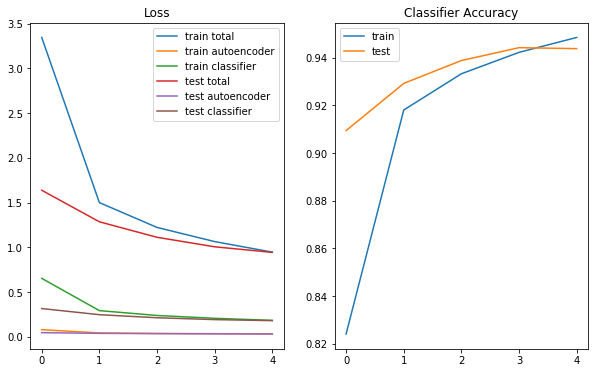

In [24]:
print(pd.DataFrame(history_2.history)[['loss', 'val_loss']].min())
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history_2.history['loss'], label='train total')
plt.plot(history_2.history['autoencoder_output_loss'], label='train autoencoder')
plt.plot(history_2.history['classifier_output_loss'], label='train classifier')
plt.plot(history_2.history['val_loss'], label='test total')
plt.plot(history_2.history['val_autoencoder_output_loss'], label='test autoencoder')
plt.plot(history_2.history['val_classifier_output_loss'], label='test classifier')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_2.history['classifier_output_accuracy'], label='train')
plt.plot(history_2.history['val_classifier_output_accuracy'], label='test')
plt.title('Classifier Accuracy')
plt.legend()

### Compare autoencoded + classified output to original images and labels

In [25]:
# Generate autoencoded images and classifier predictions
decoded2_test, prediction2_test = autoenclass.predict(X_test[test09])

decoded2_test.shape, prediction2_test.shape

((10, 784), (10, 10))

Original


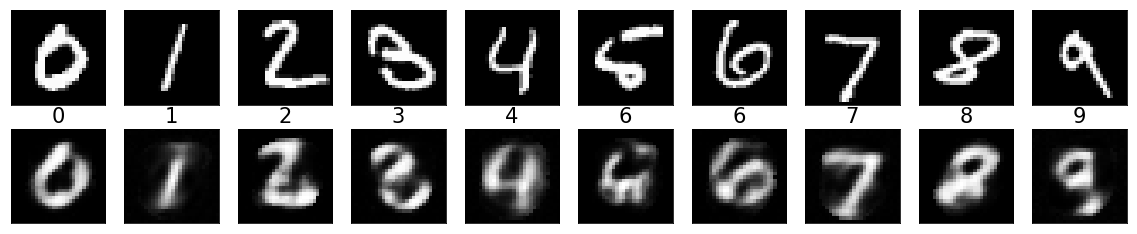

Reconstruction


In [26]:
print('Original')
plt.figure(figsize=(20, 4))
for num, i in zip(test09, range(n)):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[num].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded2_test[i].reshape(28, 28))
    ax.set_title(prediction2_test[i].argmax(axis=-1), fontsize=21)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print('Reconstruction')

### Generate encodings from the train and test sets

In [27]:
# Define encoder model
encoder_2 = Model(inputs=enc2_i, outputs=enc2_1)

N = 1000;   # Number of examples

# Generate encodings
encoded_2_train = encoder_2.predict(X_train[:N])
encoded_2_test = encoder_2.predict(X_test[:N])

encoded_2_train.shape, encoded_2_test.shape

((1000, 32), (1000, 32))

### Fit t-SNE algorithm to encodings
This cell takes ~10s to run.

In [28]:
%%time
tsne = manifold.TSNE(n_components=2,
                     perplexity=80,
                     learning_rate=200,
                     n_iter=400,
                     init='pca',
                     random_state=0)

train_2_tsne = tsne.fit_transform(encoded_2_train)
test_2_tsne = tsne.fit_transform(encoded_2_test)

train_2_tsne.shape, test_2_tsne.shape

Wall time: 11 s


((1000, 2), (1000, 2))

### Plot t-SNE results

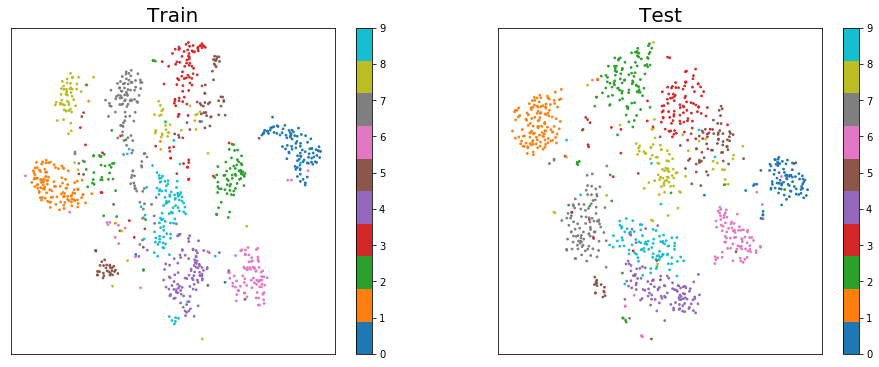

In [29]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(train_2_tsne[:,0], train_2_tsne[:,1], s=3, c=Y_train[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.scatter(test_2_tsne[:,0], test_2_tsne[:,1], s=3, c=Y_test[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Test', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

There is noticeable separation between some clusters, especially for the test data. There's also some poor separation between 9 and 4, as well as 3 and 5.

### Compare with previous t-SNE results

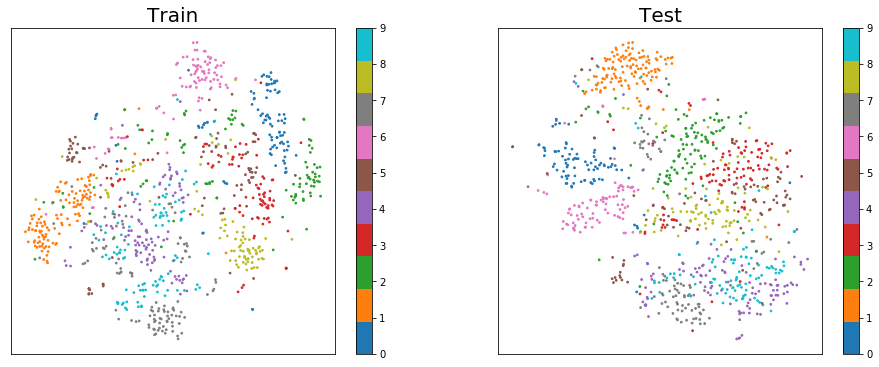

In [30]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(train_1_tsne[:,0], train_1_tsne[:,1], s=3, c=Y_train[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.scatter(test_1_tsne[:,0], test_1_tsne[:,1], s=3, c=Y_test[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Test', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

<br><br><br>
# 5. Model SubClassing
The keras API also allows model subclassing, where we can define a model architecture as a subclass of Model().<br><br>
For the example below, we can call separate sections of the network with .encoder, .classifier, etc.

In [34]:
class Autoencoder(Model):
    def __init__(self, encode_dim, layer1_dim, layer3_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(layer1_dim, activation='relu'),
            #layers.Dense(layer2_dim, activation='relu'),
            layers.Dense(encode_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            #layers.Dense(layer2_dim, activation='relu'),
            layers.Dense(layer1_dim, activation='relu'),
            layers.Dense(784, activation='sigmoid', name='autoencoder_output'),
        ])
        
        self.classifier = tf.keras.Sequential([
            layers.Dense(layer3_dim, activation='relu'),
            #layers.Dense(layer4_dim, activation='relu'),
            layers.Dense(10, activation='softmax', name='classifier_output'),
        ])
        
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded)
        return [decoded, classified]

In [35]:
autoencoder = Autoencoder(encode_dim=32, layer1_dim=64, layer3_dim=16)

autoencoder.compile(optimizer='adam',
                    loss=['mse', 'categorical_crossentropy'],
                    loss_weights=[1.0, 10.0],
                    metrics={'output_2': 'accuracy'})

In [36]:
history_3 = autoencoder.fit(x=X_train,
                          y=[X_train, Y_train_oh],
                          validation_data=(X_test, [X_test, Y_test_oh]),
                          epochs=20,
                          batch_size=256,
                          shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 35us/sample - loss: 6.7220 - output_1_loss: 0.0697 - output_2_loss: 0.6646 - output_2_accuracy: 0.7985 - val_loss: 2.5724 - val_output_1_loss: 0.0444 - val_output_2_loss: 0.2490 - val_output_2_accuracy: 0.9257
Epoch 2/20
60000/60000 [==============================] - 2s 25us/sample - loss: 2.2273 - output_1_loss: 0.0425 - output_2_loss: 0.2183 - output_2_accuracy: 0.9387 - val_loss: 1.9230 - val_output_1_loss: 0.0399 - val_output_2_loss: 0.1845 - val_output_2_accuracy: 0.9433
Epoch 3/20
60000/60000 [==============================] - 2s 25us/sample - loss: 1.6636 - output_1_loss: 0.0390 - output_2_loss: 0.1623 - output_2_accuracy: 0.9536 - val_loss: 1.6047 - val_output_1_loss: 0.0369 - val_output_2_loss: 0.1534 - val_output_2_accuracy: 0.9528
Epoch 4/20
60000/60000 [==============================] - 1s 23us/sample - loss: 1.3744 - output_1_loss: 0.0363 - output_2_loss: 0.1340 -

loss        0.290276
val_loss    1.026077
dtype: float64


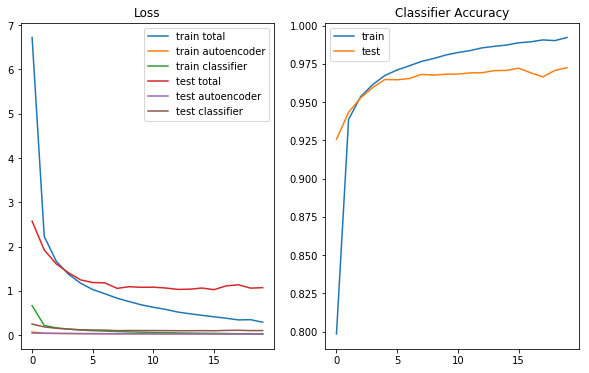

In [37]:
print(pd.DataFrame(history_3.history)[['loss', 'val_loss']].min())
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history_3.history['loss'], label='train total')
plt.plot(history_3.history['output_1_loss'], label='train autoencoder')
plt.plot(history_3.history['output_2_loss'], label='train classifier')
plt.plot(history_3.history['val_loss'], label='test total')
plt.plot(history_3.history['val_output_1_loss'], label='test autoencoder')
plt.plot(history_3.history['val_output_2_loss'], label='test classifier')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_3.history['output_2_accuracy'], label='train')
plt.plot(history_3.history['val_output_2_accuracy'], label='test')
plt.title('Classifier Accuracy')
plt.legend()

In [38]:
N = 10000;   # Number of examples

# Generate encodings
encoded_3_train = autoencoder.encoder.predict(X_train[:N])
encoded_3_test = autoencoder.encoder.predict(X_test[:N])

encoded_3_train.shape, encoded_3_test.shape

((10000, 32), (10000, 32))

In [39]:
%%time
# Cell takes >2 minutes to run for N=10,000
tsne = manifold.TSNE(n_components=2,
                     perplexity=80,
                     learning_rate=200,
                     n_iter=400,
                     init='pca',
                     random_state=0)

train_3_tsne = tsne.fit_transform(encoded_3_train)
test_3_tsne = tsne.fit_transform(encoded_3_test)

train_3_tsne.shape, test_3_tsne.shape

Wall time: 2min 20s


((10000, 2), (10000, 2))

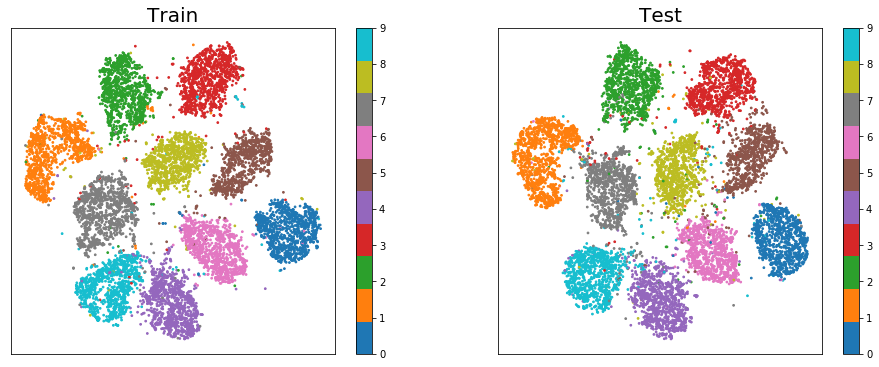

In [40]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(train_3_tsne[:,0], train_3_tsne[:,1], s=3, c=Y_train[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1,2,2)
plt.scatter(test_3_tsne[:,0], test_3_tsne[:,1], s=3, c=Y_test[:N], cmap='tab10')
plt.colorbar()
ax.set_title('Test', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [42]:
autoencoder.predict(X_train[:20])[1].argmax(axis=-1)

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=int64)

In [43]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  52320     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  53072     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  698       
Total params: 106,090
Trainable params: 106,090
Non-trainable params: 0
_________________________________________________________________


### Further exploration
Check out the blog post: https://blog.keras.io/building-autoencoders-in-keras.html <br>
for different neural network architectures trained on MNIST data,<br><br>
and the distill article: https://distill.pub/2020/grand-tour/ <br>
for analyzing and visualizing the training of a neural network on MNIST data.